<a href="https://colab.research.google.com/github/mofermino/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Kinetic_Inductance_Scatterplot_for_SC_Metals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scatterplots for Kinetic Inductances Across Different Superconducting Metals

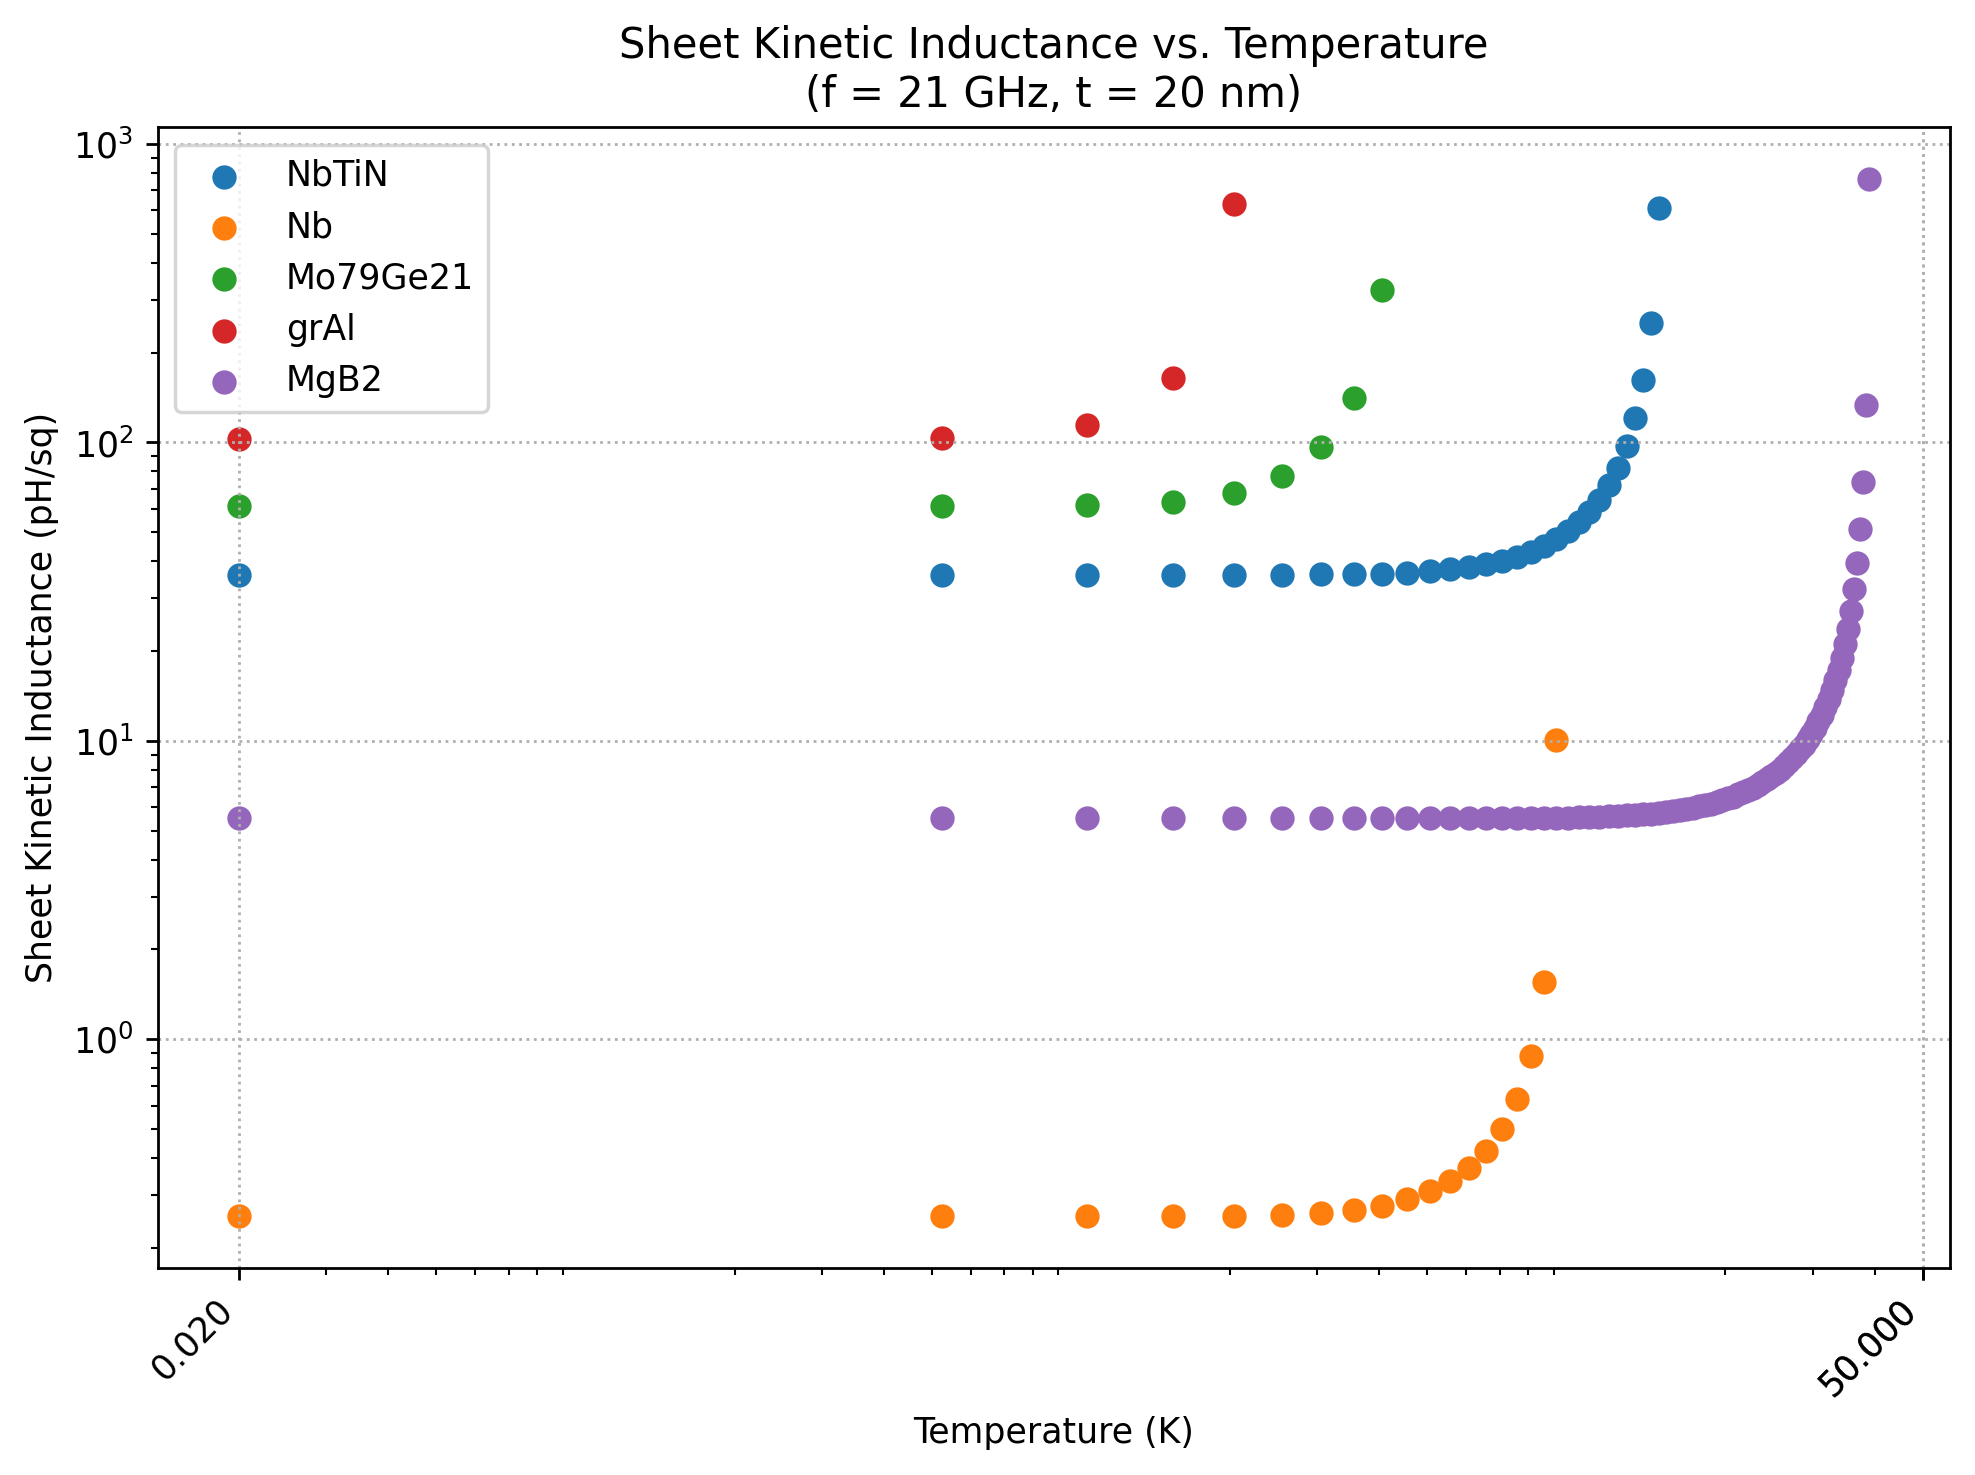

In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Plot style ----------------
plt.rcParams['figure.dpi'] = 250

# ---------------- Physics constants ----------------
hbar = 1.054571817e-34   # J*s
kB   = 1.380649e-23      # J/K
pi  = math.pi

# ---------------- Controls ----------------
freq_GHz      = 21.0        # Frequency at which to evaluate Ls(T, f)  [GHz]
thickness_nm  = 20.0       # Film thickness for scaling               [nm]
use_two_gap_MgB2 = True    # Toggle two-gap model for MgB2

# ---------------- BCS helpers ----------------
def delta_ratio_BCS(T, Tc):
    """
    Returns Δ(T)/Δ0 using a common BCS approximation.
    """
    if T <= 0:
        return 1.0
    if T >= Tc:
        return np.nan
    x = 1.74 * math.sqrt(Tc / T - 1.0)
    return math.tanh(x)

def Ls_T_from_Ls0(Ls0, T, Tc):
    """
    Your original temperature dependence (per band if needed).
    Keeps the visual behavior near Tc and low-T limit.
    Returns NaN above Tc.
    """
    if T >= Tc:
        return np.nan
    delta0_over_kBT = 1.764 * Tc / T  # (Δ0/kB)/T = 1.764 Tc / T
    ratio = delta_ratio_BCS(T, Tc)
    if ratio <= 0 or np.isnan(ratio):
        return np.nan
    x = 0.5 * delta0_over_kBT * ratio
    tanh_term = math.tanh(x)
    if tanh_term == 0:
        return np.nan
    return Ls0 * (1.0 / (ratio * tanh_term))

def bcs_gap_J(T, Tc, delta0_J=None):
    """
    Δ(T) in Joules. If delta0_J is None, uses weak-coupling BCS Δ0 = 1.764 kB Tc.
    """
    if delta0_J is None:
        delta0_J = 1.764 * kB * Tc
    r = delta_ratio_BCS(T, Tc)
    if np.isnan(r):
        return np.nan
    return delta0_J * r

def f_MB(omega, Delta_J, eps=1e-12):
    """
    Mattis–Bardeen–inspired frequency factor:
        f_MB = 1 / sqrt(max(1 - (ħω / 2Δ)^2, ε))
    Clipped to avoid divergence; only valid for ħω < 2Δ in this simplified model.
    """
    if np.isnan(Delta_J) or Delta_J <= 0.0:
        return np.nan
    x2 = (hbar * omega / (2.0 * Delta_J))**2
    denom = max(1.0 - x2, eps)
    return 1.0 / math.sqrt(denom)

# ---------------- Materials ----------------
# Ls0_pHsq is the *baseline* sheet kinetic inductance at low T & low f for a reference thickness t_ref_nm.
# For thickness scaling we use simple thin-film limit Ls ∝ 1/t (if t_ref_nm present).
# For two-gap materials, provide "weights" (sum to 1) and optional "deltas_eV".
materials = {
    "NbTiN": {
        "Ls0_pHsq": 36.0, "Tc_K": 15.0, "t_ref_nm": 20.0
        # single-gap default (BCS from Tc)
    },
    "Nb": {
        "Ls0_pHsq": 0.051, "Tc_K": 9.2, "t_ref_nm": 100.0
        # single-gap default
    },
    "Mo79Ge21": {
        "Ls0_pHsq": 61.0, "Tc_K": 4.4, "t_ref_nm": 20.0
        # single-gap default
    },
    "grAl": {
        "Ls0_pHsq": 100.0, "Tc_K": 2.2, "t_ref_nm": 20.0
        # single-gap default
    },
    "MgB2": {
        "Ls0_pHsq": 5.5, "Tc_K": 39.0, "t_ref_nm": 20.0,
        # Two-gap (illustrative):
        # If you set use_two_gap_MgB2=False above, this entry behaves as single-gap using Tc.
        "weights":   [0.6, 0.4],         # conductance split (sum to 1)
        "deltas_eV": [7.0e-3, 2.5e-3],   # Δ0 values for the two bands (at ~0 K), in eV
    },
}

# ---------------- Temperatures to sweep (x-axis) ----------------
temperatures_K = np.linspace(0.020, 50.0, 100)

# ---------------- Frequency / thickness setup ----------------
omega = 2 * math.pi * freq_GHz * 1e9               # rad/s
thickness_m = thickness_nm * 1e-9

def thickness_scale_factor(mat, t_target_nm):
    """
    Simple thin-film scaling: Ls ∝ 1/t.
    Uses material's t_ref_nm if available; otherwise returns 1.0.
    """
    t_ref = materials[mat].get("t_ref_nm", None)
    if t_ref is None or t_ref <= 0:
        return 1.0
    if t_target_nm <= 0:
        return np.nan
    return float(t_ref) / float(t_target_nm)

def Ls_sheet_singlegap_Tf(Ls0_pHsq, Tc_K, T, omega):
    """
    Single-gap sheet Ls at (T, f):
      1) Temperature dependence from your original Ls_T_from_Ls0
      2) Frequency factor f_MB(ω, Δ(T))
    """
    # temp dependence:
    Ls_T = Ls_T_from_Ls0(Ls0_pHsq, T, Tc_K)
    if np.isnan(Ls_T):
        return np.nan
    # Δ(T) using BCS:
    Delta_T_J = bcs_gap_J(T, Tc_K, delta0_J= kB * Tc_K)  # None => 1.764 kB Tc
    if np.isnan(Delta_T_J) or Delta_T_J <= 0:
        return np.nan
    # frequency factor:
    f = f_MB(omega, Delta_T_J)
    if np.isnan(f):
        return np.nan
    return Ls_T * f

def Ls_sheet_multigap_Tf(Ls0_pHsq, Tc_K, T, omega, weights, deltas_eV=None):
    """
    Two-gap (or multi-gap) support. We split Ls0 across channels by conductance weights:
        Ls0_i = Ls0 / w_i
    Then compute each band's Ls_i(T,f) and combine in parallel:
        1/Ls_total = Σ_i 1/Ls_i
    If deltas_eV is None, each band uses BCS Δ0 from Tc.
    """
    if np.isnan(T) or T >= Tc_K:
        return np.nan

    inv_sum = 0.0
    for i, w in enumerate(weights):
        w = max(float(w), 1e-12)
        Ls0_i = Ls0_pHsq / w

        # Δ0 for this band
        if deltas_eV is not None:
            delta0_J = deltas_eV[i] * 1.602176634e-19
        else:
            delta0_J = 1.764 * kB * Tc_K

        # Temperature scaling for this band's Δ(T)
        ratio = delta_ratio_BCS(T, Tc_K)
        if np.isnan(ratio) or ratio <= 0:
            continue
        Delta_T_J = delta0_J * ratio

        # Use your original temperature scaling for Ls(T) per band:
        Ls_T = Ls_T_from_Ls0(Ls0_i, T, Tc_K)
        if np.isnan(Ls_T):
            continue

        # Frequency factor for the band:
        f = f_MB(omega, Delta_T_J)
        if np.isnan(f):
            continue

        Ls_i = Ls_T * f  # pH/sq
        inv_sum += 1.0 / max(Ls_i, 1e-30)

    if inv_sum <= 0.0:
        return np.nan
    return 1.0 / inv_sum

# ---------------- Compute rows ----------------
rows = []

for mat, params in materials.items():
    Ls0 = params["Ls0_pHsq"]
    Tc  = params["Tc_K"]

    # thickness scaling: map from material's reference thickness to chosen thickness
    t_scaler = thickness_scale_factor(mat, thickness_nm)

    # multigap config if present
    weights   = params.get("weights", None)
    deltas_ev = params.get("deltas_eV", None)

    for T in temperatures_K:
        if weights is not None and use_two_gap_MgB2 and mat == "MgB2":
            Ls_Tf = Ls_sheet_multigap_Tf(Ls0, Tc, T, omega, weights, deltas_eV=deltas_ev)
        else:
            Ls_Tf = Ls_sheet_singlegap_Tf(Ls0, Tc, T, omega)

        if not np.isnan(Ls_Tf) and not np.isnan(t_scaler):
            Ls_Tf *= t_scaler  # apply thickness scaling (thin-film ~ 1/t)

        rows.append({
            "Material": mat,
            "Temperature_K": T,
            "Sheet_Kinetic_Inductance_pH_per_sq": None if (np.isnan(Ls_Tf) or np.isnan(t_scaler)) else Ls_Tf,
            "Assumed_Tc_K": Tc,
            "State": "superconducting" if (not np.isnan(Ls_Tf) and not np.isnan(t_scaler)) else "normal (not superconducting at this T)"
        })

df = pd.DataFrame(rows)

# ---------------- Plot ----------------
plt.figure(figsize=(8, 6))
for mat in materials.keys():
    sub = df[(df["Material"] == mat) & (df["State"].str.startswith("superconducting"))]
    if len(sub) == 0:
        continue
    plt.scatter(sub["Temperature_K"], sub["Sheet_Kinetic_Inductance_pH_per_sq"], label=mat)

plt.xscale("log")
plt.yscale("log")

xticks = [0.020, 50, 50]
xticklabels = [f"{x:.3f}" for x in xticks]
plt.xticks(xticks, xticklabels, rotation=45, ha="right")

plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Kinetic Inductance (pH/sq)")
plt.title(
    "Sheet Kinetic Inductance vs. Temperature\n"
    f"(f = {freq_GHz:.3g} GHz, t = {thickness_nm:.0f} nm)"
)
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()

out_path = "/content/kinetic_inductance_scatter_decimalK.png"
plt.savefig(out_path, dpi=180)
# print(out_path)


| Rank | Material (film thickness)      | $L_{k,\square}$ at 20 mK                     | Representative 45 mK value |
| ---: | ------------------------------ | -------------------------------------------- | -------------------------- |
|    1 | **Granular Al (grAl), ≲20 nm** | **∼10 nH/□** (order‑of‑nH reported)          | ≈ same (<0.1 % rise)       |
|    2 | **Mo$_{79}$Ge$_{21}$, ≈25 nm** | **tens of pH/□**; e.g., 61 pH/□ at 7.5 nm    | ≈ same (<0.1 % rise)       |
|    3 | **NbTiN, ≈10–12 nm**           | **∼35 pH/□** (typical); some report \~8 pH/□ | ≈ same (<0.1 % rise)       |
|    4 | **Nb, 200 nm**                 | **0.051 pH/□**                               | ≈ same (<0.01 % rise)      |
|    — | **MgB$_2$, ≈40 nm**    | **∼5.5 pH/□**                                | ≈ same (<0.1 % rise)       |